#### Mistral 7B

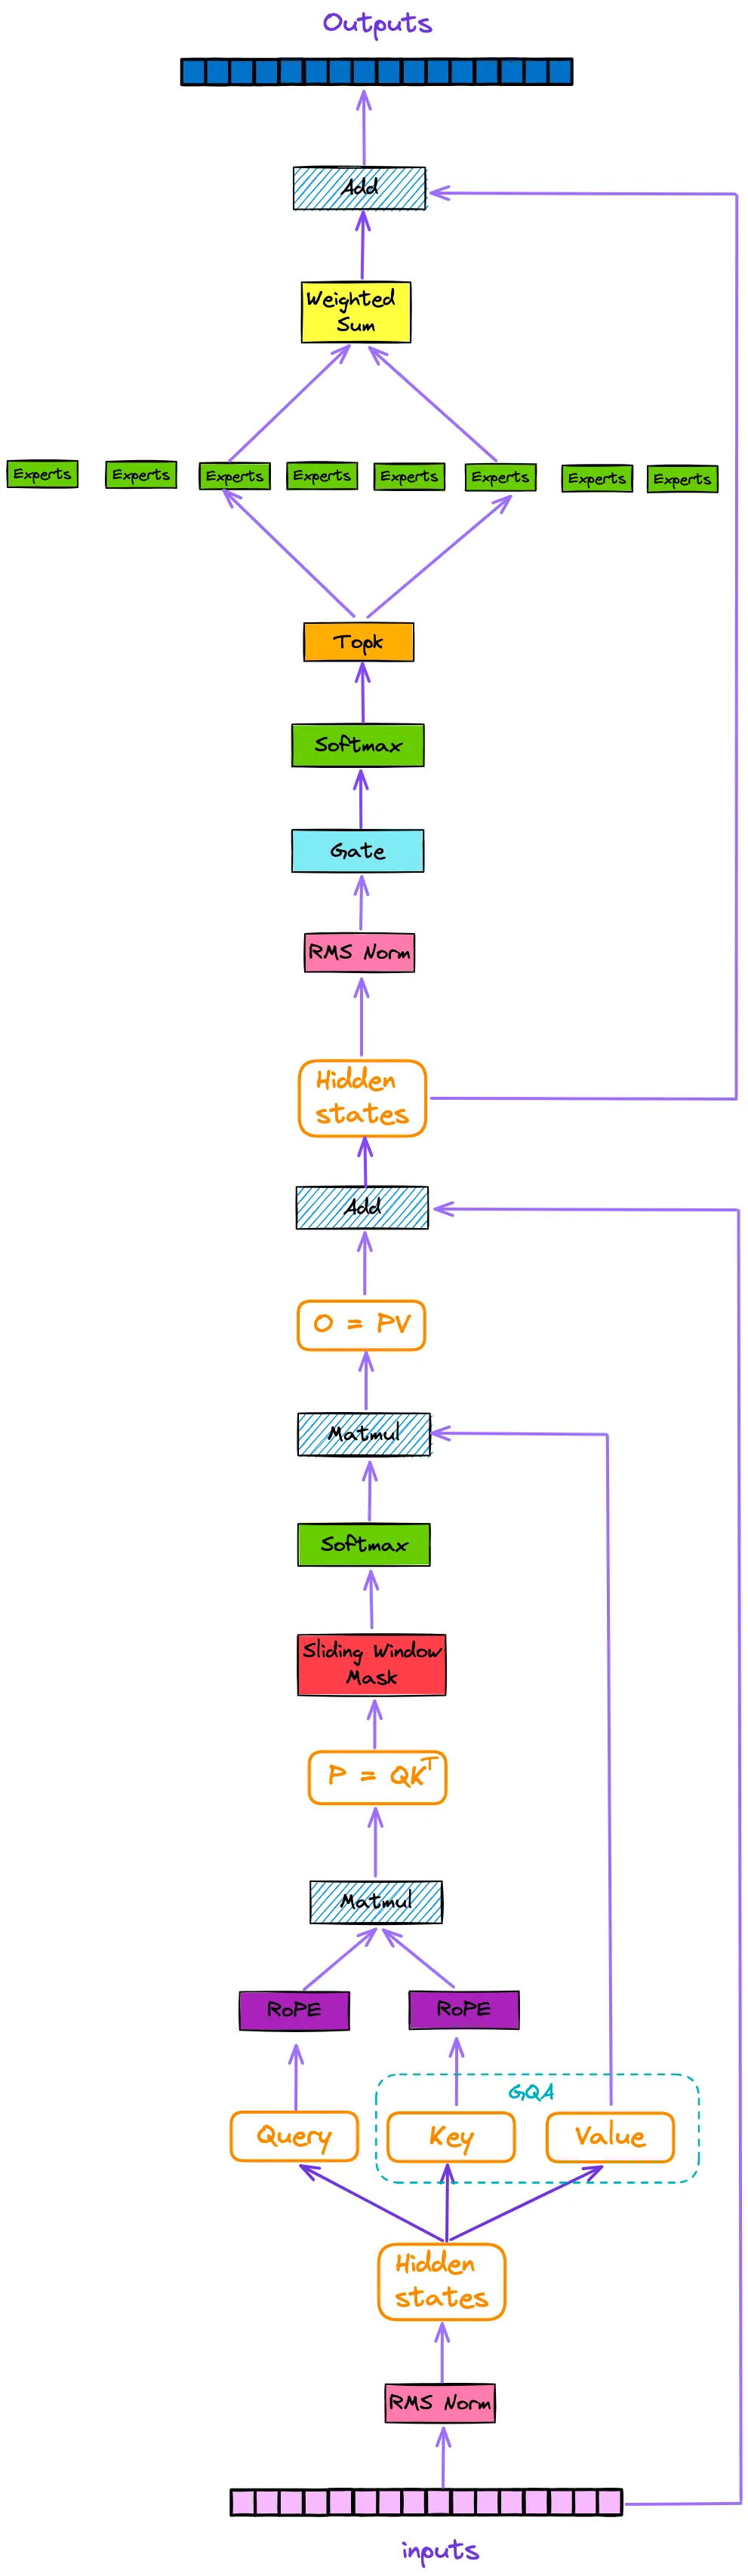

### MHA

- Attention is split across several layers (aka « heads »).
- All heads see the full input sequence.
- Each head only sees a subset embedding dimensions: **$d_{\text{hidden}}$ / num heads** has its own set of query, key, and value weight matrices.
​- All heads compute their attention scores in parallel; their scores are then concatenated.
- Main benefit: each head can explore and learn different patterns in the training data.

- Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single head, averaging inhibits this.

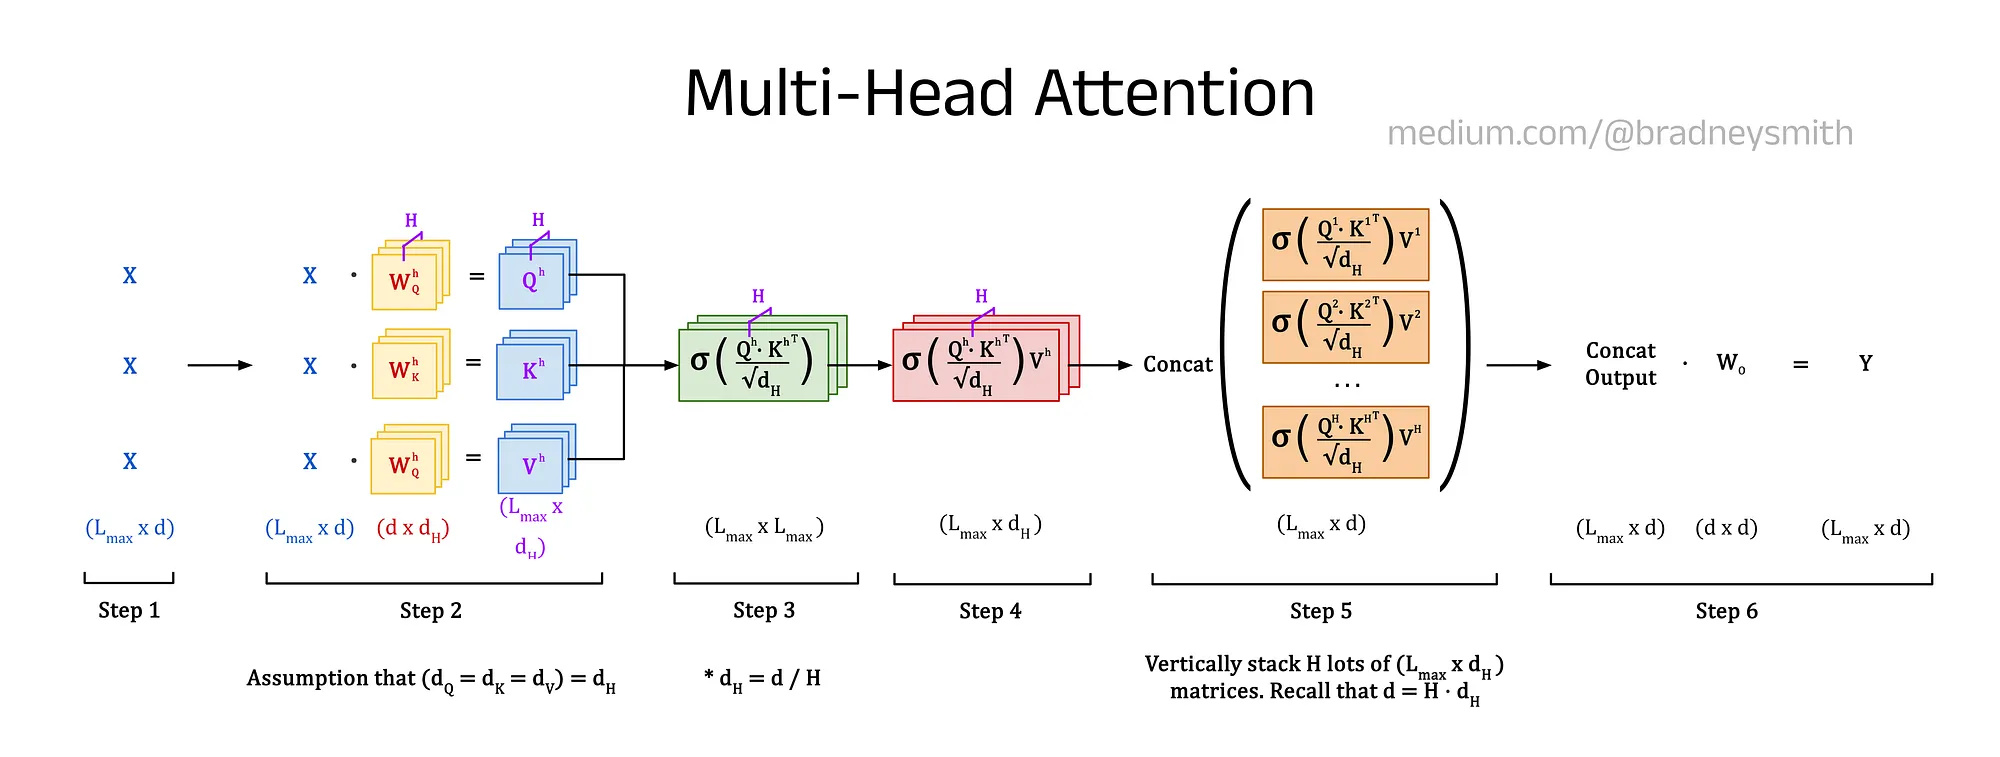

#### Computing Multi-head Attention (MHA) Outputs

$$\begin{array}{|l|c|c|l|}
\hline
\textbf{Tensor} & \textbf{Dimensions} & \textbf{Example} & \textbf{Purpose} \\ \hline
\text{Input sequence} & & & \text{The input sequence to run attention on} \\ \hline
\text{Tokenized input sequence} & N & 11 & \text{The same, in tokenized form} \\ \hline
X: \text{input embeddings} & N \times d_{\text{hidden}} & 11 \times 512 & \text{The same, in embedded form} \\ \hline
W_{Qi}: \text{query weight matrix} & & & d_{mha} = d_{\text{hidden}} / \text{number of attention heads (here, 8) = 64} \\
W_{Ki}: \text{key weight matrix} & d_{\text{hidden}} \times d_{mha} & 512 \times 64 & \\
W_{Vi}: \text{value weight matrix} & & & \text{Each head has its own weight matrices, which learn different features.} \\
W_0: \text{feed-forward weight matrix} & & & \\ \hline
Q_i = X W_{Qi}: \text{query matrix} & & & \text{All heads run this in parallel} \\
K_i = X W_{Ki}: \text{key matrix} & N \times d_{mha} & 11 \times 64 & K_i \text{ and } V_i \text{ are stored in the KV cache} \\
V_i = X W_{Vi}: \text{value matrix} & & & \\ \hline
Q_i K_i^T: \text{attention scores} & N \times N & 11 \times 11 & \text{All heads run this in parallel} \\ \hline
\text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right) V & N \times d_{mha} & 11 \times 64 & \text{All heads run this in parallel} \\ \hline
\text{Concatenate head outputs} & N \times d_{\text{hidden}} & 11 \times 512 & \\ \hline
\text{Attention output: Attention weights} \times W_0 & N \times d_{\text{hidden}} & 11 \times 512 & W_0 \text{ captures additional interactions across the sequence.} \\ \hline
\end{array}$$

### The Memory Bottleneck in Multi-head Attention (MHA)

**Standard Attention Implementation**: Requires matrices $Q, K, V \in \mathbb{R}^{N \times d}$ in High Bandwidth Memory (HBM).

**HBM Access**: The KV cache is stored in HBM, which is off-GPU.

**Complexity**: There is a quadratic complexity for HBM accesses with respect to sequence length.

**Optimization**: Techniques exist to reduce KV data transfer between the GPU and HBM, leading to variants like Multi-head Latent Attention (MLA).

### MQA

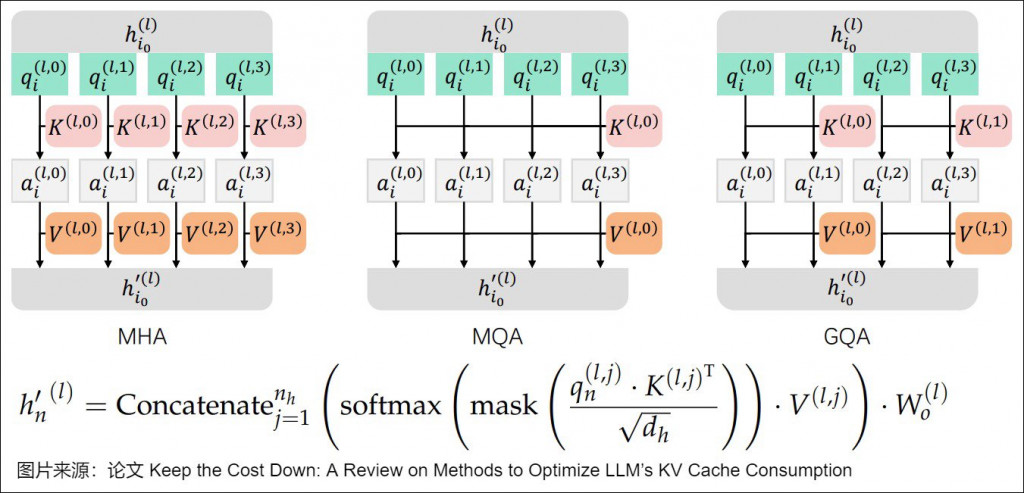

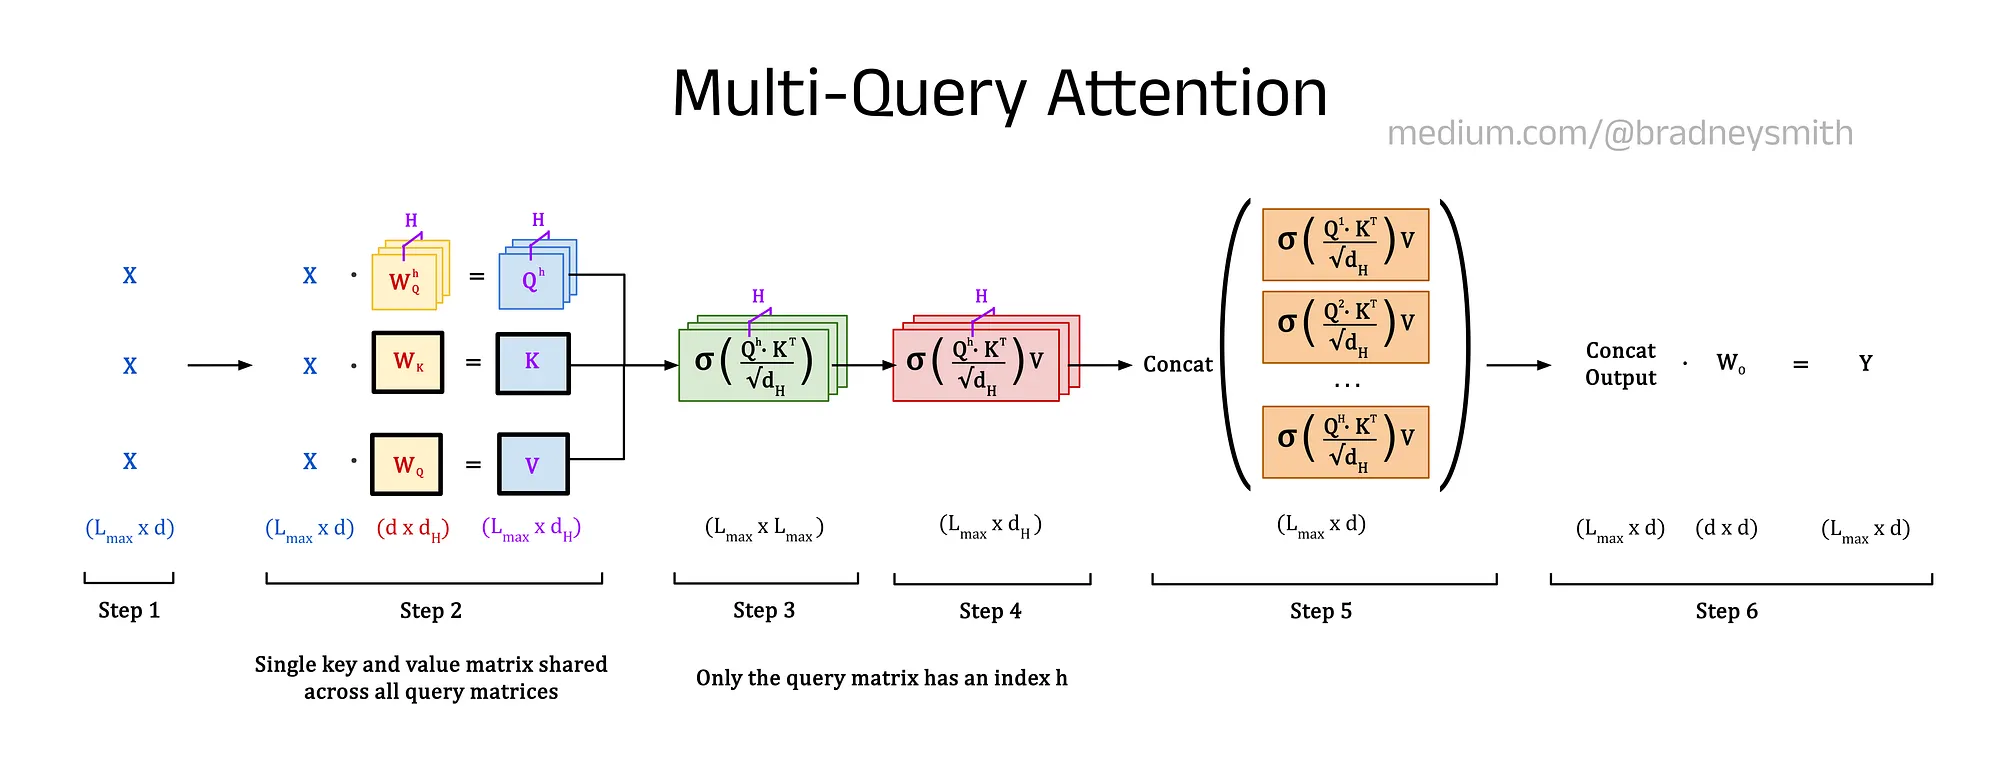

**Implementation and Benefits**
- Implemented in Falcon 7B.
- Offers a much smaller KV cache (10-100x reduction).
- Results in significantly less pressure on memory.
- Enables 12x faster decoding during the inference process.
- Reduced memory usage allows the batch size to be increased.

**Trade-offs and Requirements**
- Associated with a small drop in accuracy.
- Models must be specifically trained with MQA.
- Utilizing Tensor Parallelism requires the replication of the KV cache - which defeats the parallel processing aspect

### GQA

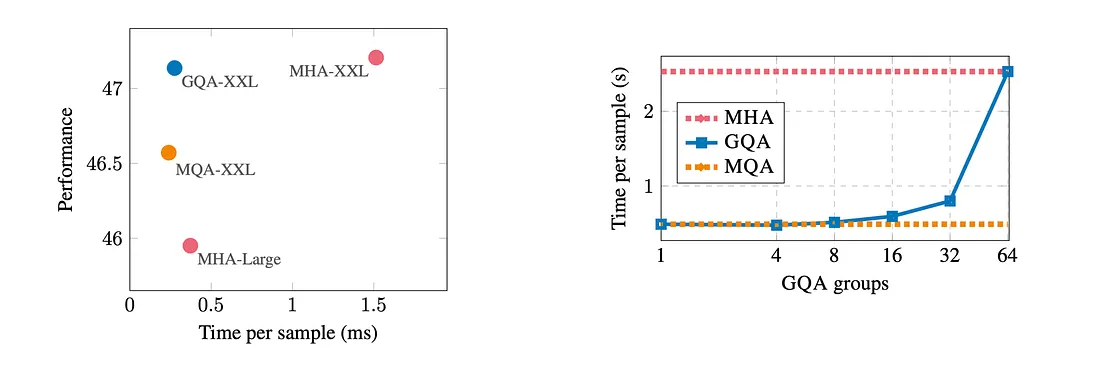

A comparison of the performance of Multi-Head, Multi-Query, and Grouped Query Attention. The left graph shows performance vs run time, showing that GQA achieves performance similar to MHA while maintaining a run time comparable to MQA. The right graph shows the relationship between the number of groups (G) in GQA and the run time, with G=32 giving strong performance and a low run time.

It's a balance between Multi-Head Attention (MHA) and Multi-Query Attention (MQA).

**Key Characteristics**
- Implemented in models like Llama 2 and Mistral.
- Attention head groups share the same set of keys and values.
- Serves as a good compromise between speed and accuracy: it is almost as accurate as MHA and almost as fast as MQA.

**Deployment and Scalability**
- Existing MHA models can be "uptrained" to use GQA.
- Provides a better fit for tensor parallelism compared to MQA.
